Verifying the findings of [LMBiS-Net](https://arxiv.org/pdf/2309.04968v1.pdf)
<br>
Paper Link - https://arxiv.org/pdf/2309.04968v1.pdf
<br>
Dataset Being Used - CHASEDB - https://researchdata.kingston.ac.uk/96/1/CHASEDB1.zip

# Imports

In [1]:
!pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.3 MB/s eta 0:00:00


In [52]:
import shutil
import random
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate
from pprint import pprint
from PIL import Image
import tensorflow_model_optimization as tfmot
import tempfile
import zipfile
import tqdm

# Global Variables and Helper Functions

In [3]:
# Global variables
EPOCHS_TO_TRAIN = 50
FIRST_HO = "1stHO"
SECOND_HO = "2ndHO"
IMAGE_SIZE = 512
DATASET_DIR = "CHASEDB_dataset"
DATASET_BATCH_SIZE = 8
TRAIN_IMAGES_DIR = f"{DATASET_DIR}/train_images_{IMAGE_SIZE}"
TRAIN_LABELS_DIR_1STHO = f"{DATASET_DIR}/train_labels_{IMAGE_SIZE}/1stHO"
TRAIN_LABELS_DIR_2NDHO = f"{DATASET_DIR}/train_labels_{IMAGE_SIZE}/2ndHO"
TEST_IMAGES_DIR = f"{DATASET_DIR}/test_images_{IMAGE_SIZE}"
TEST_LABELS_DIR_1STHO = f"{DATASET_DIR}/test_labels_{IMAGE_SIZE}/1stHO"
TEST_LABELS_DIR_2NDHO = f"{DATASET_DIR}/test_labels_{IMAGE_SIZE}/2ndHO"
CHECKPOINT_DIR = "checkpoints"

# Helper functions


def dice_coeff(y_true, y_pred, smooth=1):
    y_true = y_true / 255
    intersection = tf.keras.backend.sum(y_true * y_pred, axis=[2,3])
    sums = tf.keras.backend.sum(y_true, axis=[2,3]) + tf.keras.backend.sum(y_pred, axis=[2,3])
    dice = (2. * intersection + smooth) / (sums + smooth)
    return tf.keras.backend.mean(dice, axis=-1)

class Sensitivity(tf.keras.metrics.Metric):
    def __init__(self, name="sensitivity", **kwargs):
        super(Sensitivity, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.possible_positives = self.add_weight(name="pp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / 255
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        self.true_positives.assign_add(true_positives)
        self.possible_positives.assign_add(possible_positives)

    def result(self):
        return self.true_positives / (self.possible_positives + tf.keras.backend.epsilon())


class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name="specificity", **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name="tn", initializer="zeros")
        self.possible_negatives = self.add_weight(name="pn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / 255
        true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1 - y_true, 0, 1)))
        self.true_negatives.assign_add(true_negatives)
        self.possible_negatives.assign_add(possible_negatives)

    def result(self):
        return self.true_negatives / (self.possible_negatives + tf.keras.backend.epsilon())

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / 255
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return 2 * ((self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def iou(y_true, y_pred, smooth=tf.keras.backend.epsilon()):
    y_true = y_true / 255
    y_true_f = tf.keras.backend.batch_flatten(y_true)
    y_pred_f = tf.keras.backend.batch_flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f, axis=-1)
    union = tf.keras.backend.sum(y_true_f, axis=-1) + tf.keras.backend.sum(y_pred_f, axis=-1) - intersection
    return (intersection + smooth) / (union + smooth)

# Global variables
MODEL_COMPILE_ARGS = {
    "loss": dice_loss,
    "metrics": [
        dice_coeff,
        iou,
        Sensitivity(),
        Specificity(),
        # F1Score(),
        tf.metrics.AUC(),
    ],
}


def preprocess_image(image):
    image = image / 255.0  # Assuming the original image values were in [0, 255]
    return image


def get_generator_from_dir(dir, color_mode="rgb"):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory=dir,
        labels=None,  # Labels are not inferred since they have different names
        label_mode=None,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=DATASET_BATCH_SIZE,
        color_mode=color_mode,
        shuffle=False,
    )

def save_checkpoint(model, model_type, epoch):
    # make sure checkpoints folder exists
    if not os.path.exists("checkpoints"):
        os.mkdir("checkpoints")
    # save model
    model.save("checkpoints/model_" + model_type + "_" + str(epoch) + ".keras")
    print("Checkpoint saved: ", "model_" + model_type + "_" + str(epoch) + ".keras")


def plot_model_history(model_history):
    # plot the loss and accuracy side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(model_history.history["loss"], label="Training Loss")
    plt.legend()
    plt.subplot(122)
    plt.plot(model_history.history["dice_coeff"], label="Dice Coefficient")
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(model_history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.subplot(122)
    plt.plot(model_history.history["val_dice_coeff"], label="Validation Dice Coefficient")
    plt.legend()
    plt.show()


def load_latest_checkpoint(model_to_load, eval=False) -> (tf.keras.Model, int):
    # find the checkpoint with the highest epochs naming format model_1stHO_100.keras
    checkpoints = os.listdir("checkpoints")
    checkpoints = [i for i in checkpoints if i.startswith("model_" + model_to_load)]

    if len(checkpoints) == 0:
        print("ERROR: No checkpoints found! for model: " + model_to_load)
        return None, None

    checkpoints.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

    print("Loading checkpoint: ", checkpoints[-1])
    latest_checkpoint_num_epochs = int(checkpoints[-1].split("_")[-1].split(".")[0])

    # load the model
    model = tf.keras.models.load_model("checkpoints/" + checkpoints[-1], compile=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=MODEL_COMPILE_ARGS.get("loss"),
        metrics=MODEL_COMPILE_ARGS.get("metrics"),
    )

    if eval:
        if model_to_load == FIRST_HO:
            test_dataset = test_dataset_1stHO
        else:
            test_dataset = test_dataset_2ndHO

        # evaluate the model
        print("Evaluating the model: " + checkpoints[-1])
        model.evaluate(test_dataset)

    return model, latest_checkpoint_num_epochs


def random_test(model_to_load, model, image_to_load=None):
    # visualize the predictions in a plot with input image model prediction and ground truth
    test_images = os.listdir(f"{TEST_IMAGES_DIR}/img")
    random_image = random.choice(test_images)
    image_index = random_image.split(".")[0].split("_")[-1]

    print("Selected Image: ", random_image)
    if image_to_load:
        random_image = image_to_load
        image_index = random_image.split(".")[0].split("_")[-1]
    image_path = f"{TEST_IMAGES_DIR}/img/" + random_image
    image = Image.open(image_path).convert("RGB")
    if model_to_load == FIRST_HO:
        label_path = f"{TEST_LABELS_DIR_1STHO}/img/Image_" + image_index + "_1stHO.png"
    else:
        label_path = f"{TEST_LABELS_DIR_2NDHO}/img/Image_" + image_index + "_2ndHO.png"
    label = Image.open(label_path).convert("L")
    print("Image path: ", image_path)
    print("Label path: ", label_path)
    image = np.array(image)
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    prediction = np.squeeze(prediction, axis=0)

    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(image[0])
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(prediction)
    plt.subplot(133)
    plt.title("Ground Truth")
    plt.imshow(label)

# Fresh Dataset Preparation

In [4]:
# sanitization
if os.path.exists("CHASEDB"):
    shutil.rmtree("CHASEDB")
if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)

## Download Dataset

In [5]:
!wget https://researchdata.kingston.ac.uk/96/1/CHASEDB1.zip

--2023-11-28 01:25:12--  https://researchdata.kingston.ac.uk/96/1/CHASEDB1.zip
Resolving researchdata.kingston.ac.uk (researchdata.kingston.ac.uk)... 128.86.237.169
Connecting to researchdata.kingston.ac.uk (researchdata.kingston.ac.uk)|128.86.237.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2513926 (2.4M) [application/zip]
Saving to: ‘CHASEDB1.zip’

CHASEDB1.zip        100%[===================>]   2.40M   766KB/s    in 3.2s    

2023-11-28 01:25:16 (766 KB/s) - ‘CHASEDB1.zip’ saved [2513926/2513926]



In [6]:
!unzip CHASEDB1.zip -d CHASEDB/

Archive:  CHASEDB1.zip
  inflating: CHASEDB/Image_01L.jpg   
  inflating: CHASEDB/Image_01L_1stHO.png  
  inflating: CHASEDB/Image_01L_2ndHO.png  
  inflating: CHASEDB/Image_01R.jpg   
  inflating: CHASEDB/Image_01R_1stHO.png  
  inflating: CHASEDB/Image_01R_2ndHO.png  
  inflating: CHASEDB/Image_02L.jpg   
  inflating: CHASEDB/Image_02L_1stHO.png  
  inflating: CHASEDB/Image_02L_2ndHO.png  
  inflating: CHASEDB/Image_02R.jpg   
  inflating: CHASEDB/Image_02R_1stHO.png  
  inflating: CHASEDB/Image_02R_2ndHO.png  
  inflating: CHASEDB/Image_03L.jpg   
  inflating: CHASEDB/Image_03L_1stHO.png  
  inflating: CHASEDB/Image_03L_2ndHO.png  
  inflating: CHASEDB/Image_03R.jpg   
  inflating: CHASEDB/Image_03R_1stHO.png  
  inflating: CHASEDB/Image_03R_2ndHO.png  
  inflating: CHASEDB/Image_04L.jpg   
  inflating: CHASEDB/Image_04L_1stHO.png  
 extracting: CHASEDB/Image_04L_2ndHO.png  
  inflating: CHASEDB/Image_04R.jpg   
  inflating: CHASEDB/Image_04R_1stHO.png  
  inflating: CHASEDB/Image_0

In [7]:
!rm CHASEDB1.zip

## Image Augmentation


In [8]:
# Define the augmentation methods
def random_rotate(image, label1, label2):
    angle = random.randint(-180, 180)
    augmented_image = image.rotate(angle)
    augmented_label1 = label1.rotate(angle)
    augmented_label2 = label2.rotate(angle)
    return augmented_image, augmented_label1, augmented_label2


def random_crop(image, label1, label2):
    width, height = image.size
    crop_val = random.randint(width // 2, width)
    crop_x = random.randint(0, width - crop_val)
    crop_y = random.randint(0, height - crop_val)
    augmented_image = image.crop((crop_x, crop_y, crop_x + crop_val, crop_y + crop_val))
    augmented_label1 = label1.crop(
        (crop_x, crop_y, crop_x + crop_val, crop_y + crop_val)
    )
    augmented_label2 = label2.crop(
        (crop_x, crop_y, crop_x + crop_val, crop_y + crop_val)
    )
    return augmented_image, augmented_label1, augmented_label2


def random_brightness(image, label1, label2):
    factor = random.uniform(0.5, 1.5)
    augmented_image = Image.blend(image, image.point(lambda x: x * factor), 0.5)
    augmented_label1 = Image.blend(label1, label1.point(lambda x: x * factor), 0.5)
    augmented_label2 = Image.blend(label2, label2.point(lambda x: x * factor), 0.5)
    return augmented_image, augmented_label1, augmented_label2


def random_contrast(image, label1, label2):
    factor = random.uniform(0.5, 1.5)
    mean = np.mean(image)
    augmented_image = Image.blend(
        image, image.point(lambda x: (x - mean) * factor + mean), 0.5
    )
    augmented_label1 = Image.blend(
        label1, label1.point(lambda x: (x - mean) * factor + mean), 0.5
    )
    augmented_label2 = Image.blend(
        label2, label2.point(lambda x: (x - mean) * factor + mean), 0.5
    )
    return augmented_image, augmented_label1, augmented_label2


def random_flip(image, label1, label2):
    augmented_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_label1 = label1.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_label2 = label2.transpose(Image.FLIP_LEFT_RIGHT)
    return augmented_image, augmented_label1, augmented_label2

def random_hue(image, label1, label2):
    factor = random.uniform(0.5, 1.5)
    augmented_image = Image.blend(image, image.point(lambda x: x * factor), 0.5)
    return augmented_image, label1, label2

def random_augment(image, label1, label2):
    # Randomly choose one of the augmentation methods
    aug_methods = [
        random_rotate,
        random_crop,
        random_brightness,
        random_contrast,
        random_flip,
        random_hue,
    ]
    # random number of augmentations to perform
    number_of_augmentations_to_perform = random.randint(1, len(aug_methods))

    # choose a random augmentation method make sure it is not applied twice
    augmentations_to_perform = []
    for _ in range(number_of_augmentations_to_perform):
        aug_method = random.choice(aug_methods)
        while aug_method in augmentations_to_perform:
            aug_method = random.choice(aug_methods)
        augmentations_to_perform.append(aug_method)

    # apply the augmentation methods
    for aug_method in augmentations_to_perform:
        image, label1, label2 = aug_method(image, label1, label2)

    return image, label1, label2

In [9]:
images = []
dir_list = os.listdir("CHASEDB")
for i in dir_list:
    if i.endswith(".jpg"):
        image = i
        label1 = i[:-4] + "_1stHO.png"
        label2 = i[:-4] + "_2ndHO.png"
        images.append((image, label1, label2))

# sort the images list
images.sort(key=lambda x: x[0])
pprint(images)

[('Image_01L.jpg', 'Image_01L_1stHO.png', 'Image_01L_2ndHO.png'),
 ('Image_01R.jpg', 'Image_01R_1stHO.png', 'Image_01R_2ndHO.png'),
 ('Image_02L.jpg', 'Image_02L_1stHO.png', 'Image_02L_2ndHO.png'),
 ('Image_02R.jpg', 'Image_02R_1stHO.png', 'Image_02R_2ndHO.png'),
 ('Image_03L.jpg', 'Image_03L_1stHO.png', 'Image_03L_2ndHO.png'),
 ('Image_03R.jpg', 'Image_03R_1stHO.png', 'Image_03R_2ndHO.png'),
 ('Image_04L.jpg', 'Image_04L_1stHO.png', 'Image_04L_2ndHO.png'),
 ('Image_04R.jpg', 'Image_04R_1stHO.png', 'Image_04R_2ndHO.png'),
 ('Image_05L.jpg', 'Image_05L_1stHO.png', 'Image_05L_2ndHO.png'),
 ('Image_05R.jpg', 'Image_05R_1stHO.png', 'Image_05R_2ndHO.png'),
 ('Image_06L.jpg', 'Image_06L_1stHO.png', 'Image_06L_2ndHO.png'),
 ('Image_06R.jpg', 'Image_06R_1stHO.png', 'Image_06R_2ndHO.png'),
 ('Image_07L.jpg', 'Image_07L_1stHO.png', 'Image_07L_2ndHO.png'),
 ('Image_07R.jpg', 'Image_07R_1stHO.png', 'Image_07R_2ndHO.png'),
 ('Image_08L.jpg', 'Image_08L_1stHO.png', 'Image_08L_2ndHO.png'),
 ('Image_0

In [10]:
# split the images into train and test sets
random.seed(42)
random.shuffle(images)
train_images = images[:20]
test_images = images[20:]
print("num train_images: ", len(train_images))
print("num test_images: ", len(test_images))

num train_images:  20
num test_images:  8


In [11]:
# Prepare directories
if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)

os.makedirs(f"{TRAIN_IMAGES_DIR}/img")
os.makedirs(f"{TRAIN_LABELS_DIR_1STHO}/img")
os.makedirs(f"{TRAIN_LABELS_DIR_2NDHO}/img")
os.makedirs(f"{TEST_IMAGES_DIR}/img")
os.makedirs(f"{TEST_LABELS_DIR_1STHO}/img")
os.makedirs(f"{TEST_LABELS_DIR_2NDHO}/img")

In [12]:
# Prepare Test set
for i in test_images:
    # resize and save
    image = Image.open("CHASEDB/" + i[0]).convert("RGB")
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image.save(f"{TEST_IMAGES_DIR}/img/" + i[0])
    os.remove("CHASEDB/" + i[0])

    label1 = Image.open("CHASEDB/" + i[1]).convert("L")
    label1 = label1.resize((IMAGE_SIZE, IMAGE_SIZE))
    label1.save(f"{TEST_LABELS_DIR_1STHO}/img/" + i[1])
    os.remove("CHASEDB/" + i[1])

    label2 = Image.open("CHASEDB/" + i[2]).convert("L")
    label2 = label2.resize((IMAGE_SIZE, IMAGE_SIZE))
    label2.save(f"{TEST_LABELS_DIR_2NDHO}/img/" + i[2])
    os.remove("CHASEDB/" + i[2])

In [13]:
print(f"Augmenting the training set and resizing to: {IMAGE_SIZE}x{IMAGE_SIZE}")

# Augment the training set
# Augment each one of them 37 times - to get approx the same number of images as the paper
for i in range(len(train_images)):
    image = Image.open("CHASEDB/" + train_images[i][0]).convert("RGB")
    label1 = Image.open("CHASEDB/" + train_images[i][1]).convert("L")
    label2 = Image.open("CHASEDB/" + train_images[i][2]).convert("L")
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    label1 = label1.resize((IMAGE_SIZE, IMAGE_SIZE))
    label2 = label2.resize((IMAGE_SIZE, IMAGE_SIZE))
    for j in range(37):
        augmented_image, augmented_label1, augmented_label2 = random_augment(
            image, label1, label2
        )
        augmented_image.save(
            f'{TRAIN_IMAGES_DIR}/img/' + train_images[i][0][:-4] + "_" + str(j) + ".jpg"
        )
        augmented_label1.save(
            f'{TRAIN_LABELS_DIR_1STHO}/img/' + train_images[i][1][:-4] + "_" + str(j) + ".png"
        )
        augmented_label2.save(
            f'{TRAIN_LABELS_DIR_2NDHO}/img/' + train_images[i][2][:-4] + "_" + str(j) + ".png"
        )
    os.remove("CHASEDB/" + train_images[i][0])
    os.remove("CHASEDB/" + train_images[i][1])
    os.remove("CHASEDB/" + train_images[i][2])

os.rmdir("CHASEDB")

Augmenting the training set and resizing to: 512x512


## Verify Augmentation

total Augmentations:  740
random_selection:  Image_07R_9.jpg


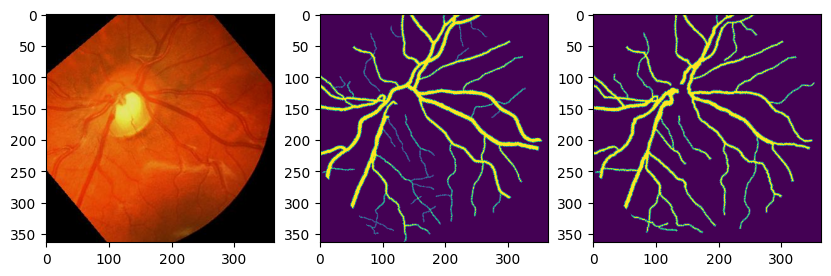

In [14]:
# Show a set of augmented image with its labels to verify
augmented_images = os.listdir(f"{TRAIN_IMAGES_DIR}/img")
random_image = random.choice(augmented_images)
index = random_image.split("_")[-1].split(".")[0]
eye_type = random_image.split("_")[1]

print("total Augmentations: ", int(len(augmented_images)))
print("random_selection: ", random_image)

image = Image.open(f"{TRAIN_IMAGES_DIR}/img/" + random_image).convert("RGB")
label1 = Image.open(f"{TRAIN_LABELS_DIR_1STHO}/img/Image_" + eye_type + "_1stHO_" + index + ".png").convert("L")
label2 = Image.open(f"{TRAIN_LABELS_DIR_2NDHO}/img/Image_" + eye_type + "_2ndHO_" + index + ".png").convert("L")

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(label1)
plt.subplot(133)
plt.imshow(label2)
plt.show()

# Dataset Loading

In [15]:
# Load train and test sets

# Train Set
train_data_gen = get_generator_from_dir(TRAIN_IMAGES_DIR)
train_label_gen_1stHO = get_generator_from_dir(TRAIN_LABELS_DIR_1STHO, color_mode="grayscale")
train_label_gen_2ndHO = get_generator_from_dir(TRAIN_LABELS_DIR_2NDHO, color_mode="grayscale")
train_data_gen = train_data_gen.map(lambda image: preprocess_image(image))
train_dataset_1stHO = tf.data.Dataset.zip((train_data_gen, train_label_gen_1stHO))
train_dataset_2ndHO = tf.data.Dataset.zip((train_data_gen, train_label_gen_2ndHO))

# Test Set
test_data_gen = get_generator_from_dir(TEST_IMAGES_DIR)
test_label_gen_1stHO = get_generator_from_dir(TEST_LABELS_DIR_1STHO, color_mode="grayscale")
test_label_gen_2ndHO = get_generator_from_dir(TEST_LABELS_DIR_2NDHO, color_mode="grayscale")
test_data_gen = test_data_gen.map(lambda image: preprocess_image(image))
test_dataset_1stHO = tf.data.Dataset.zip((test_data_gen, test_label_gen_1stHO))
test_dataset_2ndHO = tf.data.Dataset.zip((test_data_gen, test_label_gen_2ndHO))

# make a validation set
dataset_size = 740
validation_percent = 10
validation_size = int(dataset_size * validation_percent / 100)
train_dataset_1stHO = train_dataset_1stHO.shuffle(dataset_size)
train_dataset_2ndHO = train_dataset_2ndHO.shuffle(dataset_size)
val_dataset_1stHO = train_dataset_1stHO.take(validation_size)
val_dataset_2ndHO = train_dataset_2ndHO.take(validation_size)
train_dataset_1stHO = train_dataset_1stHO.skip(validation_size)
train_dataset_2ndHO = train_dataset_2ndHO.skip(validation_size)



Found 740 files belonging to 1 classes.
Found 740 files belonging to 1 classes.
Found 740 files belonging to 1 classes.
Found 8 files belonging to 1 classes.
Found 8 files belonging to 1 classes.
Found 8 files belonging to 1 classes.


# Model Architecture

In [16]:
def prepare_fresh_model():
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    input_data = Input(shape=input_shape)

    def multipath_feature_extraction_block(inputs):
        # Define kernel sizes for 1x1, 3x3, and 5x5 convolutions
        kernel_sizes = [1, 3, 5]
        pathway_outputs = []

        for kernel_size in kernel_sizes:
            conv = Conv2D(64, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(inputs)
            conv = BatchNormalization()(conv)
            pathway_outputs.append(conv)

        aggregated_output = tf.keras.layers.Add()(pathway_outputs)
        pathway_outputs = []

        # Run convolutions a second time.
        for kernel_size in kernel_sizes:
            conv = Conv2D(64, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(aggregated_output)
            conv = BatchNormalization()(conv)
            pathway_outputs.append(conv)

        aggregated_output = tf.keras.layers.Add()(pathway_outputs)

        return aggregated_output

    # Encoder Block
    def encoder_block(inputs, filters):
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        #x = MaxPooling2D(pool_size=(2, 2))(x)
        return x

    # Encoder Block with Multipath block
    def encoder_block_w_multipath(inputs, filters):
        x = multipath_feature_extraction_block(inputs)
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        # Potentially re-add maxpool here.
        return x

    def max_pool(inputs):
        x = MaxPooling2D(pool_size=(2, 2))(inputs)
        return x

    encoder_stage1 = encoder_block(input_data, 32)
    maxpool1 = max_pool(encoder_stage1)

    encoder_stage2 = encoder_block_w_multipath(maxpool1, 64)
    maxpool2 = max_pool(encoder_stage2)

    encoder_stage3 = encoder_block_w_multipath(maxpool2, 128)
    maxpool3 = max_pool(encoder_stage3)

    def botteneck_block(inputs, filters):
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        return x

    # Bottleneck Layer
    bottleneck = botteneck_block(maxpool3, 64)

    # Decoder Block
    def decoder_block(inputs, skip_connection, filters):
        x = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
        x = Concatenate()([x, skip_connection])
        x = BatchNormalization()(x)
        x = multipath_feature_extraction_block(x)
        return x

    decoder1 = decoder_block(bottleneck, encoder_stage3, 128)
    decoder2 = decoder_block(decoder1, encoder_stage2, 64)

    # Decoder 3
    x = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder2)
    x = Concatenate()([x, encoder_stage1])
    x = BatchNormalization()(x)

    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)
    #x = BatchNormalization()(x)

    model = tf.keras.Model(inputs=input_data, outputs=x)
    return model

In [17]:
def get_fresh_models():
    # load fresh Model
    model_1stHO = prepare_fresh_model()
    model_2ndHO = tf.keras.models.clone_model(model_1stHO)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model_1stHO.compile(optimizer = optimizer, loss = MODEL_COMPILE_ARGS.get("loss"), metrics = MODEL_COMPILE_ARGS.get("metrics"))
    model_2ndHO.compile(optimizer = optimizer, loss = MODEL_COMPILE_ARGS.get("loss"), metrics = MODEL_COMPILE_ARGS.get("metrics"))

    return model_1stHO, model_2ndHO

# Model Training

In [ ]:
# Delete Checkpoints folder if starting fresh
if os.path.exists(CHECKPOINT_DIR):
    shutil.rmtree(CHECKPOINT_DIR)

In [ ]:
# Start Fresh - make sure to run Cells under Model Architecture to start fresh
continue_training = False
model_1stHO, model_2ndHO = get_fresh_models()

In [ ]:
model_1stHO.summary()

In [19]:
# Continue Training - If one of the models is not trained yet then run the start fresh cell before running this cell
if not os.path.exists(CHECKPOINT_DIR):
    raise Exception("No checkpoints found!")
continue_training = True
model_1stHO_num_epochs = 0
model_2ndHO_num_epochs = 0

FirstHO_Load = load_latest_checkpoint(FIRST_HO)
SecondHO_Load = load_latest_checkpoint(SECOND_HO)

if FirstHO_Load[1] is not None:
    model_1stHO, model_1stHO_num_epochs = FirstHO_Load
if SecondHO_Load[1] is not None:
    model_2ndHO, model_2ndHO_num_epochs = SecondHO_Load

Loading checkpoint:  model_1stHO_200.keras
ERROR: No checkpoints found! for model: 2ndHO


In [ ]:
!zip -r checkpoints.zip checkpoints/

updating: checkpoints/ (stored 0%)
  adding: checkpoints/model_1stHO_150.keras (deflated 9%)
  adding: checkpoints/model_1stHO_200.keras (deflated 9%)
  adding: checkpoints/model_1stHO_100.keras (deflated 9%)
  adding: checkpoints/.ipynb_checkpoints/ (stored 0%)
  adding: checkpoints/model_1stHO_50.keras (deflated 9%)


In [18]:
!unzip checkpoints.zip

Archive:  checkpoints.zip
   creating: checkpoints/
  inflating: checkpoints/model_1stHO_150.keras  
  inflating: checkpoints/model_1stHO_200.keras  
  inflating: checkpoints/model_1stHO_100.keras  
  inflating: checkpoints/model_1stHO_50.keras  
  inflating: checkpoints/keras_prune.h5  
  inflating: checkpoints/model_pruned_50_1stHO_200.keras  


Save a checkpoint to continue training as without saving between re runs of fit function the epoch count for save model will not work as intended, it relies on the saved models to figureout how many epochs have been run, it cannot judge how many epochs have been run from the history object

## Train for 1stHO

In [ ]:
# Train the model with the first label
history_1stHO = model_1stHO.fit(train_dataset_1stHO, epochs=EPOCHS_TO_TRAIN, validation_data=val_dataset_1stHO)
if continue_training:
    epoch_num = model_1stHO_num_epochs + EPOCHS_TO_TRAIN
else:
    epoch_num = EPOCHS_TO_TRAIN
save_checkpoint(model_1stHO, FIRST_HO, epoch_num)

Epoch 1/50
19/19 [==============================] - 66s 3s/step - loss: 0.2562 - dice_coeff: 0.7438 - iou: 0.6124 - sensitivity: 0.8807 - specificity: 0.9804 - auc_1: 0.6212 - val_loss: 0.2755 - val_dice_coeff: 0.7245 - val_iou: 0.5860 - val_sensitivity: 0.8307 - val_specificity: 0.9812 - val_auc_1: 0.6147
Epoch 2/50
19/19 [==============================] - 52s 3s/step - loss: 0.2518 - dice_coeff: 0.7482 - iou: 0.6169 - sensitivity: 0.8833 - specificity: 0.9818 - auc_1: 0.6157 - val_loss: 0.2733 - val_dice_coeff: 0.7267 - val_iou: 0.5923 - val_sensitivity: 0.8492 - val_specificity: 0.9794 - val_auc_1: 0.6161
Epoch 3/50
19/19 [==============================] - 54s 3s/step - loss: 0.2449 - dice_coeff: 0.7551 - iou: 0.6300 - sensitivity: 0.8824 - specificity: 0.9822 - auc_1: 0.6206 - val_loss: 0.2526 - val_dice_coeff: 0.7474 - val_iou: 0.6170 - val_sensitivity: 0.8929 - val_specificity: 0.9786 - val_auc_1: 0.6251
Epoch 4/50
19/19 [==============================] - 54s 3s/step - loss: 0.26

### Plots

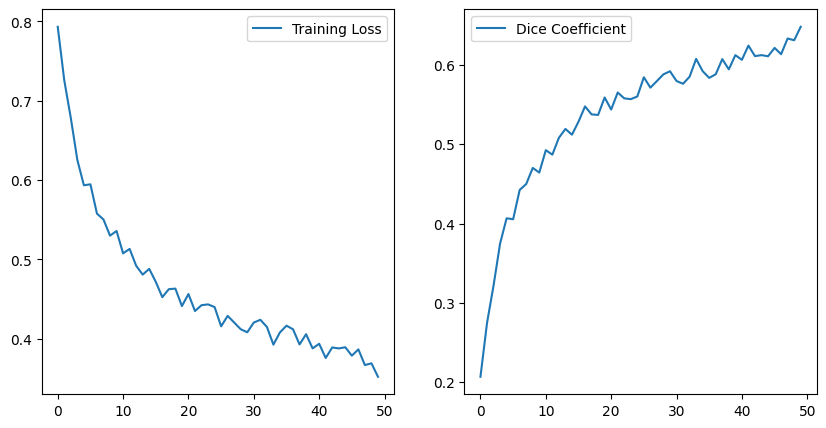

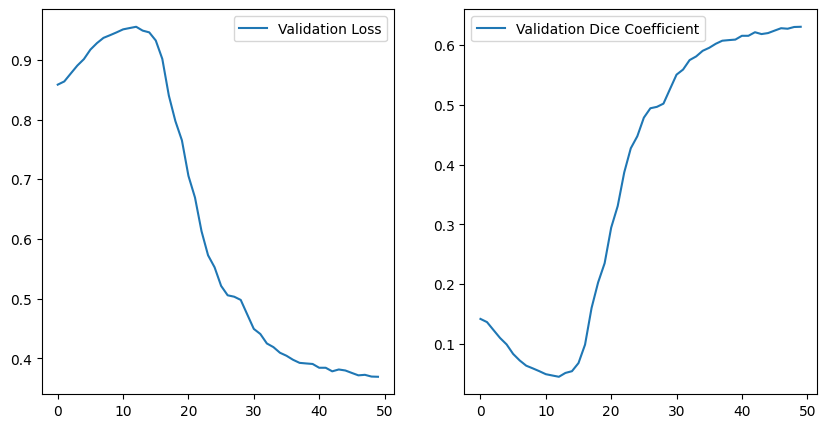

In [ ]:
# 50
plot_model_history(history_1stHO)

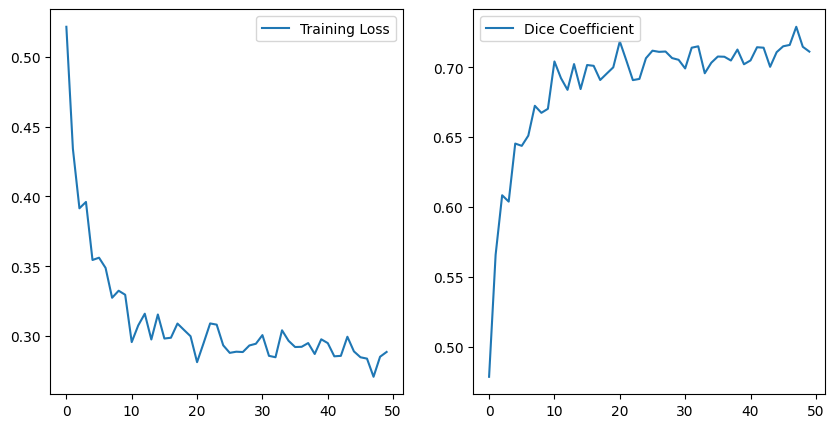

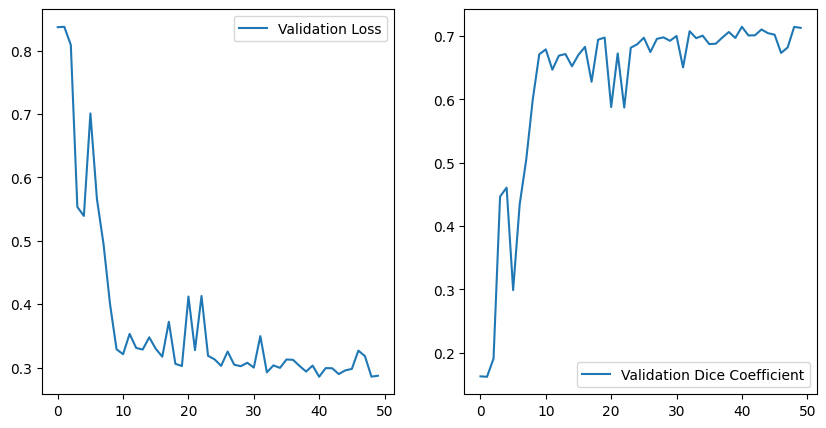

In [ ]:
# 100
plot_model_history(history_1stHO)

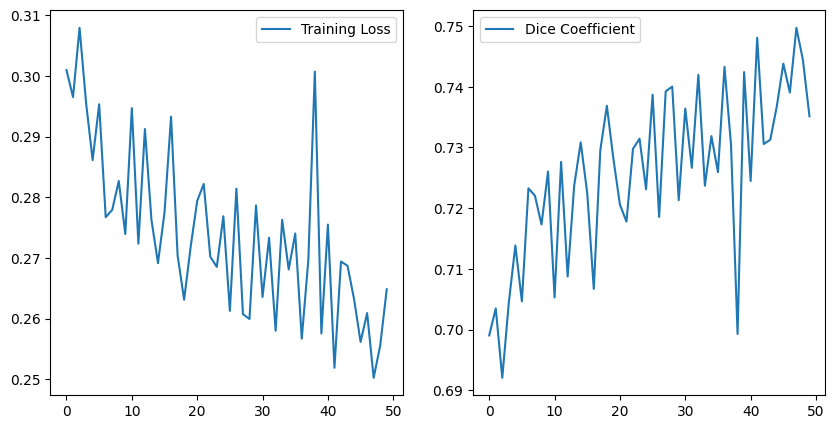

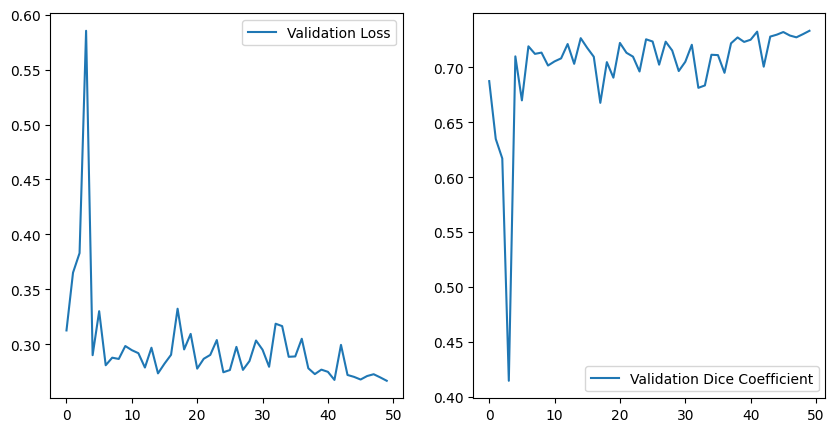

In [ ]:
# 150
plot_model_history(history_1stHO)

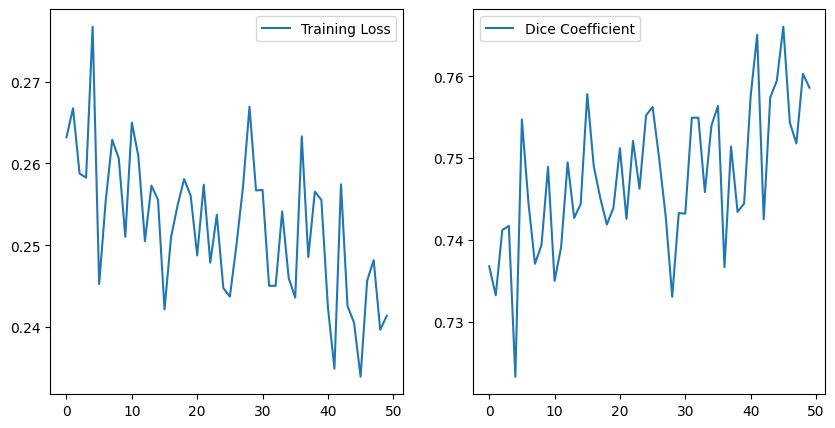

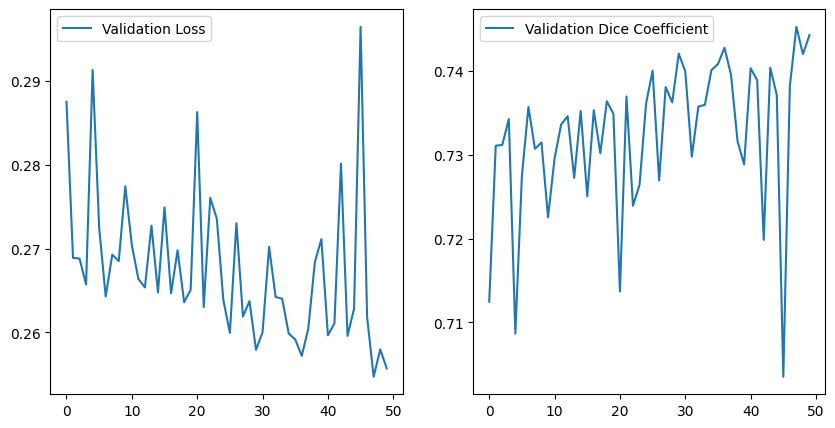

In [ ]:
# 200
plot_model_history(history_1stHO)

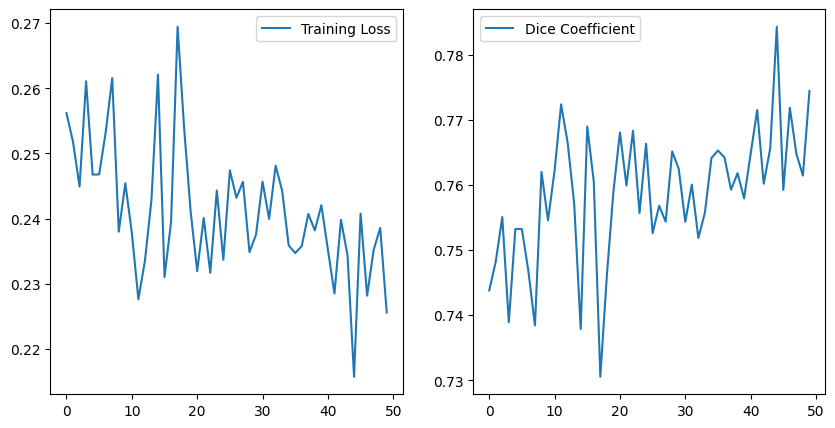

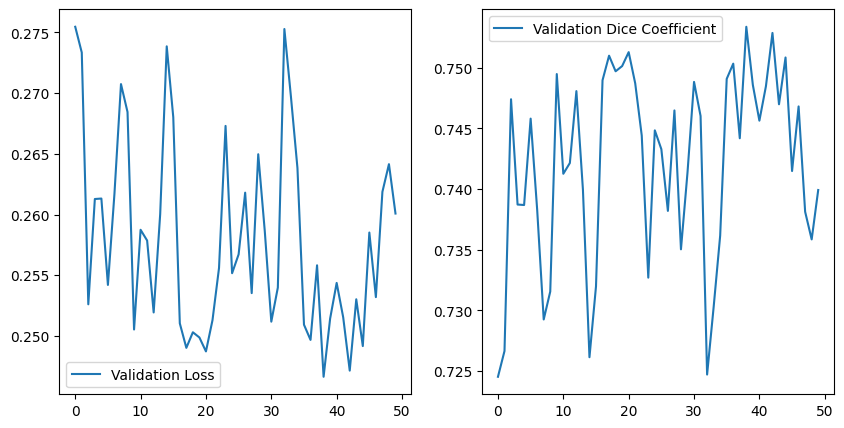

In [ ]:
# 250
plot_model_history(history_1stHO)

## Train for 2ndHO

In [ ]:
# Train the model with the second label
history_2ndHO = model_2ndHO.fit(train_dataset_2ndHO, epochs=EPOCHS_TO_TRAIN, validation_data=val_dataset_2ndHO)
if continue_training:
    epoch_num = model_2ndHO_num_epochs + EPOCHS_TO_TRAIN
else:
    epoch_num = EPOCHS_TO_TRAIN
save_checkpoint(model_2ndHO, SECOND_HO, epoch_num)

Epoch 1/50


KeyboardInterrupt: ignored

### Plots

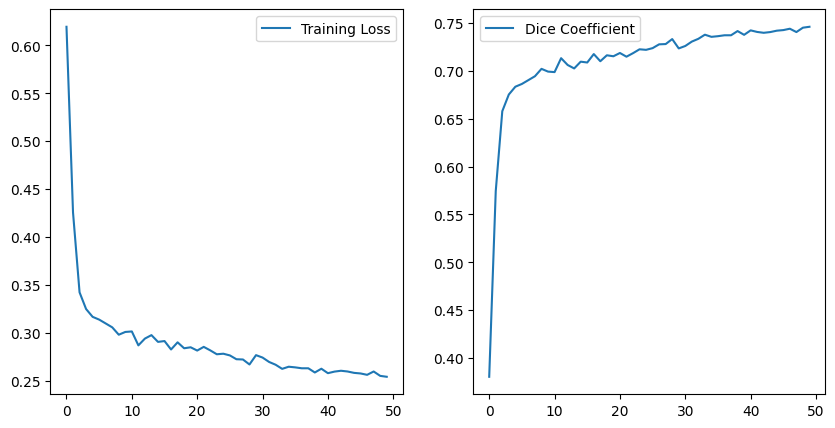

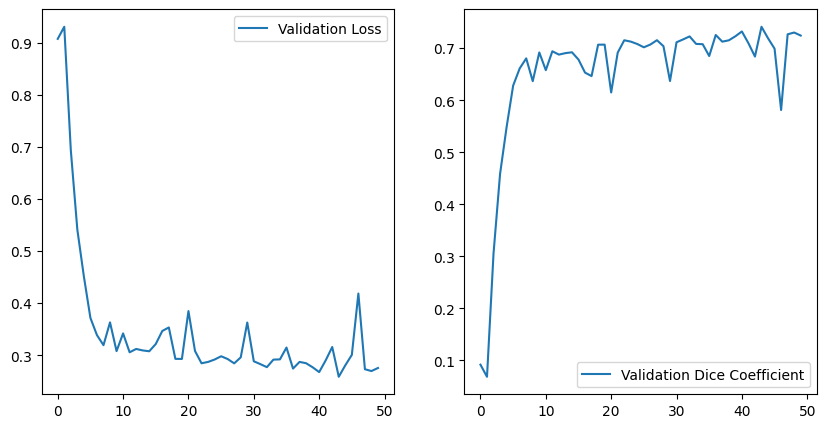

In [ ]:
#50
plot_model_history(history_2ndHO)

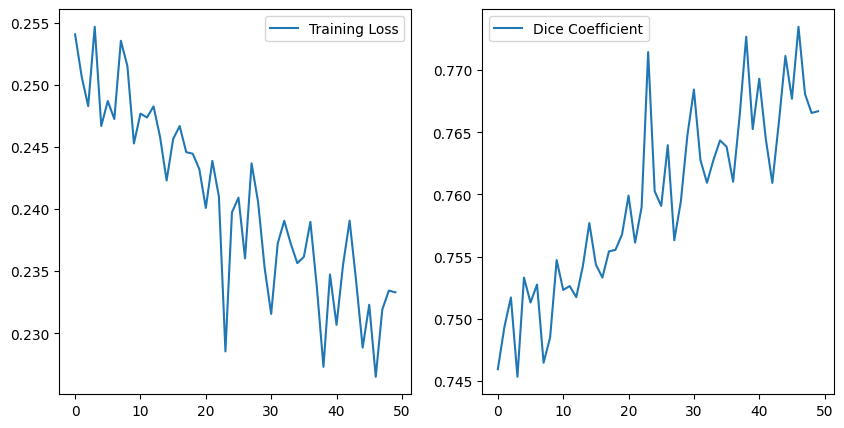

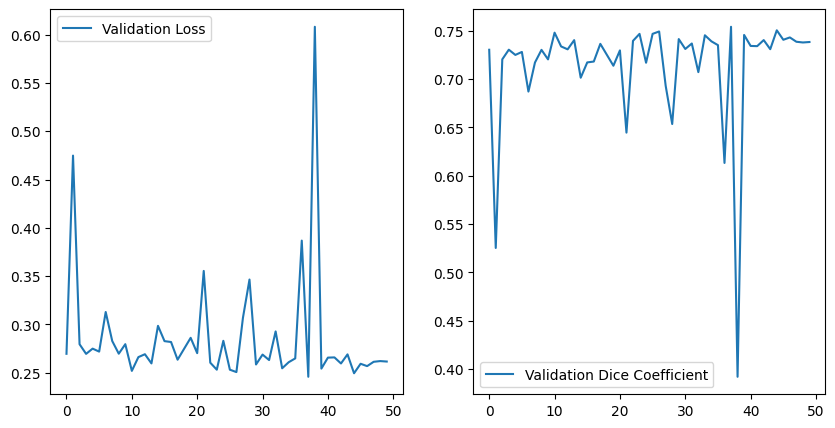

In [ ]:
#100
plot_model_history(history_2ndHO)

# Model Evaluation


## Evaluate for 1stHO

In [ ]:
model_to_load = FIRST_HO
eval_model,_ = load_latest_checkpoint(model_to_load, eval=True)

Loading checkpoint:  model_1stHO_200.keras
Evaluating the model: model_1stHO_200.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - auc: 0.8779 - dice_coeff: 0.5923 - f1_score: 0.7371 - iou: 0.4005 - loss: 0.4077 - sensitivity: 0.8913 - specificity: 0.9398


Selected Image:  Image_11L.jpg
Image path:  CHASEDB_dataset/test_images_512/img/Image_04R.jpg
Label path:  CHASEDB_dataset/test_labels_512/1stHO/img/Image_04R_1stHO.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


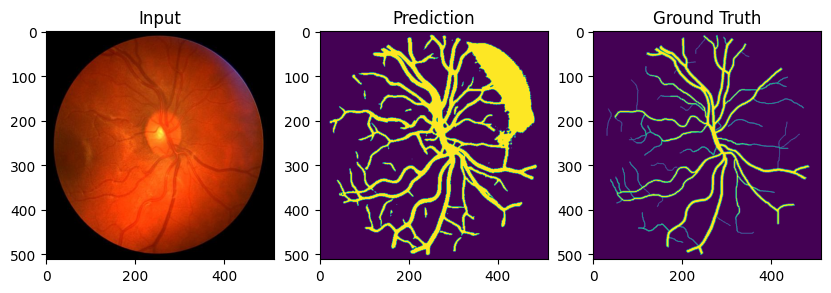

In [ ]:
random_test(model_to_load, eval_model, image_to_load="Image_04R.jpg")
# random_test(model_to_load, eval_model)

In [ ]:
model_to_load = FIRST_HO
eval_model,_ = load_latest_checkpoint(model_to_load, eval=True)

Loading checkpoint:  model_1stHO_200.keras
Evaluating the model: model_1stHO_200.keras
1/1 [==============================] - 15s 15s/step - loss: 0.1986 - dice_coeff: 0.8014 - iou: 0.6676 - sensitivity: 0.8573 - specificity: 0.9810 - auc: 0.8570


Selected Image:  Image_05L.jpg
Image path:  CHASEDB_dataset/test_images_512/img/Image_04R.jpg
Label path:  CHASEDB_dataset/test_labels_512/1stHO/img/Image_04R_1stHO.png
1/1 [==============================] - 1s 657ms/step


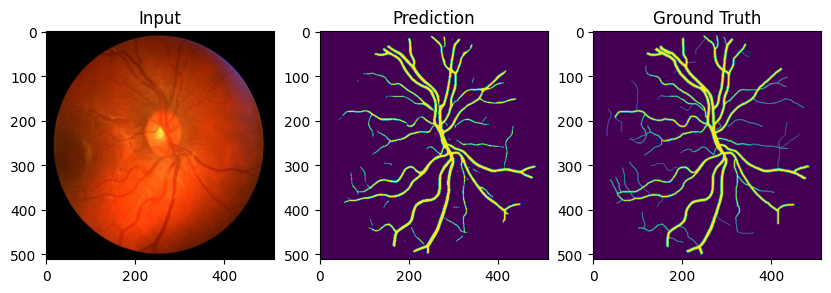

In [ ]:
random_test(model_to_load, eval_model, image_to_load="Image_04R.jpg")

## Evaluate for 2ndHO

In [ ]:
model_to_load = SECOND_HO
eval_model,_ = load_latest_checkpoint(model_to_load, eval=True)

Loading checkpoint:  model_2ndHO_300.keras
Evaluating the model: model_2ndHO_300.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - auc: 0.6250 - dice_coeff: 0.4948 - f1_score: 0.3974 - iou: 0.3039 - loss: 0.5052 - sensitivity: 0.8307 - specificity: 0.9806


Selected Image:  Image_11L.jpg
Image path:  CHASEDB_dataset/test_images_512/img/Image_04R.jpg
Label path:  CHASEDB_dataset/test_labels_512/2ndHO/img/Image_04R_2ndHO.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


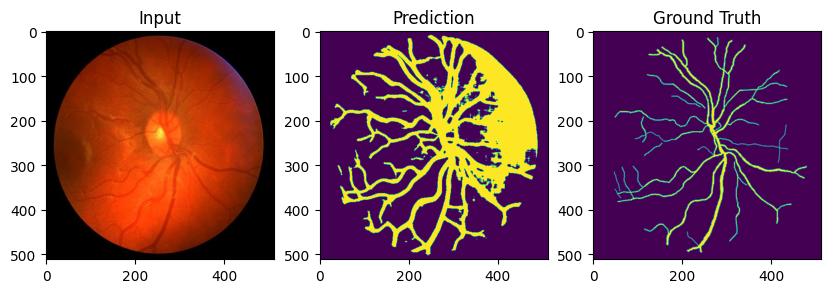

In [ ]:
random_test(model_to_load, eval_model, image_to_load="Image_04R.jpg")

In [ ]:
model_to_load = SECOND_HO
eval_model,_ = load_latest_checkpoint(model_to_load, eval=True)

Loading checkpoint:  model_2ndHO_100.keras
Evaluating the model: model_2ndHO_100.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - auc: 0.6265 - dice_coeff: 0.7684 - f1_score: 0.4015 - iou: 0.6151 - loss: 0.2316 - sensitivity: 0.8310 - specificity: 0.9800


Selected Image:  Image_04R.jpg
Image path:  CHASEDB_dataset/test_images_512/img/Image_04R.jpg
Label path:  CHASEDB_dataset/test_labels_512/2ndHO/img/Image_04R_2ndHO.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


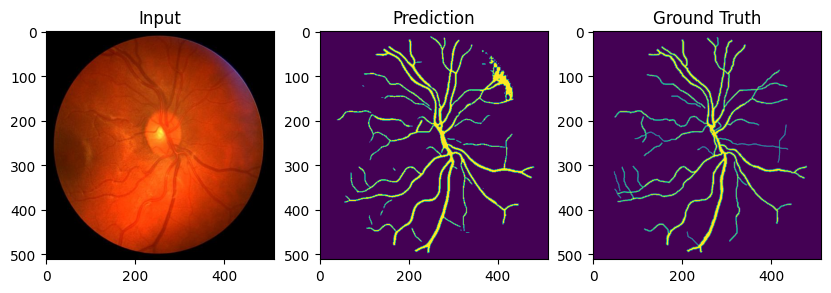

In [ ]:
random_test(model_to_load, eval_model, image_to_load="Image_04R.jpg")

# Optimization

In [20]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
end_step = np.ceil(740 / 8).astype(np.int32) * 10

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model_1stHO, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_for_pruning.compile(optimizer = optimizer, loss = MODEL_COMPILE_ARGS.get("loss"), metrics = MODEL_COMPILE_ARGS.get("metrics"))

In [21]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_dataset_1stHO, validation_data=val_dataset_1stHO,
                  batch_size=8, epochs=50,
                  callbacks=callbacks)

Epoch 1/50
 6/19 [========>.....................] - ETA: 15s - loss: 0.2729 - dice_coeff: 0.7271 - iou: 0.5999 - sensitivity: 0.8912 - specificity: 0.9786 - auc: 0.6020

19/19 [==============================] - 137s 3s/step - loss: 0.2499 - dice_coeff: 0.7501 - iou: 0.6179 - sensitivity: 0.8778 - specificity: 0.9798 - auc: 0.6334 - val_loss: 0.2605 - val_dice_coeff: 0.7395 - val_iou: 0.6075 - val_sensitivity: 0.8523 - val_specificity: 0.9826 - val_auc: 0.6170
Epoch 2/50
19/19 [==============================] - 54s 3s/step - loss: 0.2413 - dice_coeff: 0.7587 - iou: 0.6302 - sensitivity: 0.8816 - specificity: 0.9825 - auc: 0.6309 - val_loss: 0.2577 - val_dice_coeff: 0.7423 - val_iou: 0.6120 - val_sensitivity: 0.8705 - val_specificity: 0.9808 - val_auc: 0.6182
Epoch 3/50
19/19 [==============================] - 54s 3s/step - loss: 0.2347 - dice_coeff: 0.7653 - iou: 0.6355 - sensitivity: 0.8872 - specificity: 0.9820 - auc: 0.6326 - val_loss: 0.2609 - val_dice_coeff: 0.7391 - val_iou: 0.6069 - val_sensitivity: 0.9063 - val_specificity: 0.9738 - val_auc: 0.6266
Epoch 4/50
19/19 [==============================] - 54s 3s/step - loss: 0.2543 - dice_coeff: 0.745

In [37]:
model_type = FIRST_HO
epoch = 200
model_for_pruning.save("checkpoints/model_pruned_50_" + model_type + "_" + str(epoch) + ".keras")

In [39]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in kilobytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1000

In [40]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.save("checkpoints/pruned_keras.keras")

In [41]:
model_for_export_test = tf.keras.models.load_model("checkpoints/pruned_keras.keras")

In [43]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

In [44]:
with open('checkpoints/tf_lite_converted.tflite', 'wb') as f:
    f.write(pruned_tflite_model)

In [45]:
print("Before Pruning ",get_gzipped_model_size("checkpoints/model_1stHO_200.keras"), " KB")
print("After Pruning ",get_gzipped_model_size("checkpoints/model_pruned_50_1stHO_200.keras"), " KB")
print("After conversion",get_gzipped_model_size("checkpoints/tf_lite_converted.tflite"), " KB")

Before Pruning  22546.994  KB
After Pruning  20206.68  KB
After conversion 2427.542  KB


In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

In [47]:
with open("checkpoints/tf_lite_converted_quantized.tflite", 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

In [48]:
print("Size of gzipped baseline Keras model: %.2f KB" % (get_gzipped_model_size("checkpoints/tf_lite_converted.tflite")))
print("Size of gzipped pruned and quantized TFlite model: %.2f KB" % (get_gzipped_model_size("checkpoints/tf_lite_converted_quantized.tflite")))

Size of gzipped baseline Keras model: 2427.54 KB
Size of gzipped pruned and quantized TFlite model: 761.86 KB


In [49]:
# Load the TFLite model
tflite_model_path = "checkpoints/tf_lite_converted_quantized.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

In [55]:
def evaluate_tflite_model(interpreter, dataset):
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    total_samples = 0
    total_dice = 0

    # Wrap the dataset with tqdm to display a progress bar
    for batch_images, batch_labels in tqdm.tqdm(dataset, desc="Evaluating", unit="batch", leave=False):
        for i in range(batch_images.shape[0]):
            # Prepare the input tensor
            input_data = tf.convert_to_tensor([batch_images[i]], dtype=tf.float32)
            interpreter.set_tensor(input_index, input_data)

            # Run inference
            interpreter.invoke()

            # Get the output tensor
            output = interpreter.get_tensor(output_index)

            # Extract the true binary mask
            true_mask = tf.convert_to_tensor([batch_labels[i]], dtype=tf.float32)

            # Calculate Dice coefficient
            current_dice = dice_coeff(true_mask, output)

            # Update metrics
            total_samples += 1
            total_dice += current_dice

    mean_dice = total_dice / total_samples
    return mean_dice.numpy()[0]

In [56]:
print("Mean Dice_coeff after conversion to tf_lite: ",evaluate_tflite_model(interpreter, test_dataset_1stHO))

Mean Dice_coeff after conversion to tf_lite:  0.79763526
